In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Setting up the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
logger.info("Loading data...")

# Load datasets
train = pd.read_csv('../data/train.csv', low_memory=False)
test = pd.read_csv('../data/test.csv', low_memory=False)
store = pd.read_csv('../data/store.csv', low_memory=False)

# Merge store information with train and test datasets
train = pd.merge(train, store, on='Store', how='left')
test = pd.merge(test, store, on='Store', how='left')

logger.info("Data loaded successfully")
logger.info(f"Train dataset shape: {train.shape}")
logger.info(f"Test dataset shape: {test.shape}")
print(train.columns)

INFO:__main__:Loading data...
INFO:__main__:Data loaded successfully
INFO:__main__:Train dataset shape: (1017209, 18)
INFO:__main__:Test dataset shape: (41088, 17)


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [3]:
logger.info("Handling missing values...")

# Fill missing values
train['CompetitionDistance'].fillna(train['CompetitionDistance'].median(), inplace=True)
train['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
train['CompetitionOpenSinceYear'].fillna(0, inplace=True)
train['Promo2SinceWeek'].fillna(0, inplace=True)
train['Promo2SinceYear'].fillna(0, inplace=True)
train['PromoInterval'].fillna(0, inplace=True)

test['CompetitionDistance'].fillna(test['CompetitionDistance'].median(), inplace=True)
test['CompetitionOpenSinceMonth'].fillna(0, inplace=True)
test['CompetitionOpenSinceYear'].fillna(0, inplace=True)
test['Promo2SinceWeek'].fillna(0, inplace=True)
test['Promo2SinceYear'].fillna(0, inplace=True)
test['PromoInterval'].fillna(0, inplace=True)
test['Open'].fillna(1, inplace=True)

logger.info("Missing values handled")

# Verify there are no more missing values
logger.info(f"Remaining missing values in the train dataset:\n{train.isnull().sum()}")
logger.info(f"Remaining missing values in the test dataset:\n{test.isnull().sum()}")

INFO:__main__:Handling missing values...
INFO:__main__:Missing values handled
INFO:__main__:Remaining missing values in the train dataset:
Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64
INFO:__main__:Remaining missing values in the test dataset:
Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday

In [4]:
logger.info("Converting non-numeric columns to numeric...")

# Convert categorical variables to numeric
train['StateHoliday'] = train['StateHoliday'].map({'0': 0, 'a': 1, 'b': 2, 'c': 3})
test['StateHoliday'] = test['StateHoliday'].map({'0': 0, 'a': 1, 'b': 2, 'c': 3})

train['StoreType'] = train['StoreType'].map({'a': 1, 'b': 2, 'c': 3, 'd': 4})
test['StoreType'] = test['StoreType'].map({'a': 1, 'b': 2, 'c': 3, 'd': 4})

train['Assortment'] = train['Assortment'].map({'a': 1, 'b': 2, 'c': 3})
test['Assortment'] = test['Assortment'].map({'a': 1, 'b': 2, 'c': 3})

# Extract datetime features
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train['DayOfWeek'] = train['Date'].dt.dayofweek

test['Date'] = pd.to_datetime(test['Date'])
test['Year'] = test['Date'].dt.year
test['Month'] = test['Date'].dt.month
test['Day'] = test['Date'].dt.day
test['DayOfWeek'] = test['Date'].dt.dayofweek

logger.info("Conversion completed")

INFO:__main__:Converting non-numeric columns to numeric...
INFO:__main__:Conversion completed


In [5]:
logger.info("Feature engineering...")

# Weekend feature
train['Weekend'] = train['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)
test['Weekend'] = test['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Holidays feature
def days_to_next_holiday(date, holidays):
    return (holidays[holidays > date].min() - date).days if (holidays > date).any() else 0

def days_since_last_holiday(date, holidays):
    return (date - holidays[holidays < date].max()).days if (holidays < date).any() else 0

holidays = pd.to_datetime(['2013-12-25', '2014-12-25', '2015-12-25'])  # Add other holidays as necessary

train['DaysToHoliday'] = train['Date'].apply(lambda x: days_to_next_holiday(x, holidays))
train['DaysSinceHoliday'] = train['Date'].apply(lambda x: days_since_last_holiday(x, holidays))

test['DaysToHoliday'] = test['Date'].apply(lambda x: days_to_next_holiday(x, holidays))
test['DaysSinceHoliday'] = test['Date'].apply(lambda x: days_since_last_holiday(x, holidays))

# Month features
train['BeginningOfMonth'] = train['Day'].apply(lambda x: 1 if x <= 10 else 0)
train['MidMonth'] = train['Day'].apply(lambda x: 1 if 10 < x <= 20 else 0)
train['EndOfMonth'] = train['Day'].apply(lambda x: 1 if x > 20 else 0)

test['BeginningOfMonth'] = test['Day'].apply(lambda x: 1 if x <= 10 else 0)
test['MidMonth'] = test['Day'].apply(lambda x: 1 if 10 < x <= 20 else 0)
test['EndOfMonth'] = test['Day'].apply(lambda x: 1 if x > 20 else 0)

logger.info("Feature engineering completed")


INFO:__main__:Feature engineering...
INFO:__main__:Feature engineering completed


In [6]:
logger.info("Building the model pipeline...")

# Define features and target variable
features = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'Year', 'Month', 'Day', 'Weekend', 'DaysToHoliday', 'DaysSinceHoliday', 'BeginningOfMonth', 'MidMonth', 'EndOfMonth']
target = 'Sales'

X = train[features]
y = train[target]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline
pipeline = Pipeline([
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred = pipeline.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
logger.info(f'Mean Absolute Error: {mae}')

INFO:__main__:Building the model pipeline...
INFO:__main__:Mean Absolute Error: 502.94475128046315


INFO:__main__:Analyzing feature importance...


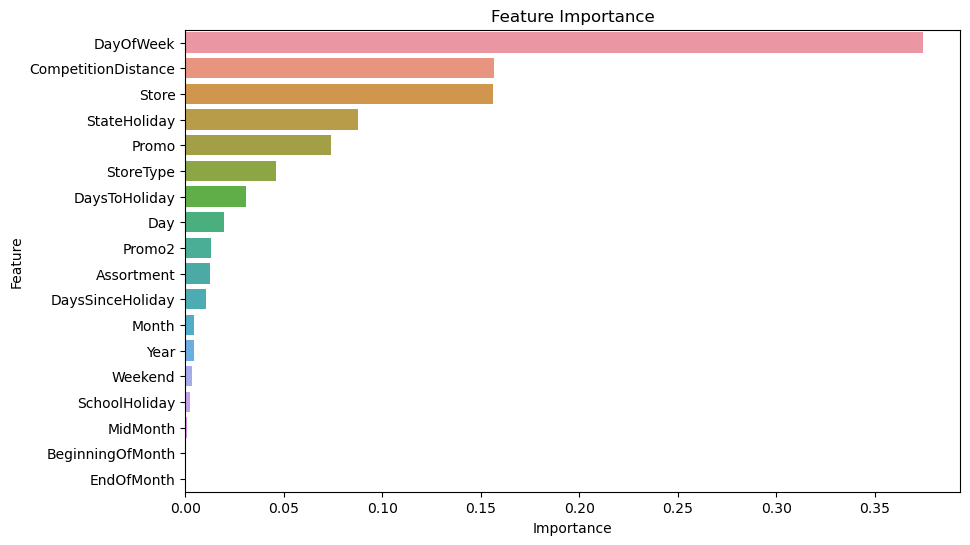

In [7]:
logger.info("Analyzing feature importance...")

importances = pipeline.named_steps['model'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [11]:
logger.info("Estimating confidence intervals...")

n_iterations = 2
n_size = int(len(X_val) * 0.5)
predictions = []

for i in range(n_iterations):
    sample_index = np.random.choice(X_val.index, n_size, replace=True)
    X_sample = X_val.loc[sample_index]
    y_sample = y_val.loc[sample_index]
    y_pred = pipeline.predict(X_sample)
    predictions.append(y_pred)

predictions = np.array(predictions)

# Calculate the lower and upper percentile (e.g., 2.5th and 97.5th percentiles)
lower_percentile = np.percentile(predictions, 2.5, axis=0)
upper_percentile = np.percentile(predictions, 97.5, axis=0)

# Log the results
logger.info(f"Estimated lower confidence interval: {lower_percentile}")
logger.info(f"Estimated upper confidence interval: {upper_percentile}")


INFO:__main__:Estimating confidence intervals...
INFO:__main__:Estimated lower confidence interval: [8087.559    161.18825 4163.82225 ...  266.93175 7393.96375 4621.81925]
INFO:__main__:Estimated upper confidence interval: [ 8514.641    6286.34175 10382.98775 ... 10410.33825  8723.72625
  7728.29075]


INFO:__main__:Building LSTM model...
INFO:__main__:Checking for stationarity...
INFO:__main__:ADF Statistic: -4.761615
INFO:__main__:p-value: 0.000064
INFO:__main__:Critical Values: 1%, -3.437470108019385
INFO:__main__:Critical Values: 5%, -2.8646832620852853
INFO:__main__:Critical Values: 10%, -2.5684436698650503


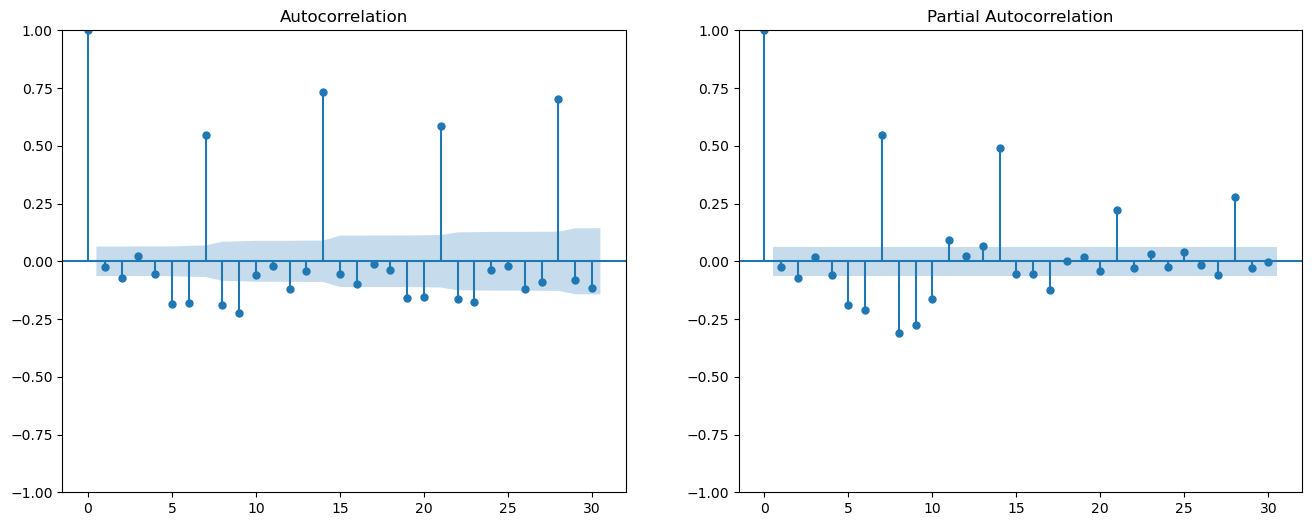

C:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
INFO:__main__:Training the LSTM model...


Epoch 1/20
 28/700 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 54168001708032.0000

C:\Users\User\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


700/700 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 38919936671744.0000 - val_loss: 73233151819776.0000
Epoch 2/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 45790818992128.0000 - val_loss: 19856237789184.0000
Epoch 3/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 16078289764352.0000 - val_loss: 18768656859136.0000
Epoch 4/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 17507840688128.0000 - val_loss: 16815994437632.0000
Epoch 5/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 14539196203008.0000 - val_loss: 17921002700800.0000
Epoch 6/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 14306246656000.0000 - val_loss: 18247629930496.0000
Epoch 7/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 15291260076032.0000 - val_loss: 18172667232256.0000
Epoch 8/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 23614877335552.0000 - val_loss: 18979731013632.0000
Epoch 9/20
700/700 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 14921244868608.0000 - val_loss: 15025278287872.0000
Epo

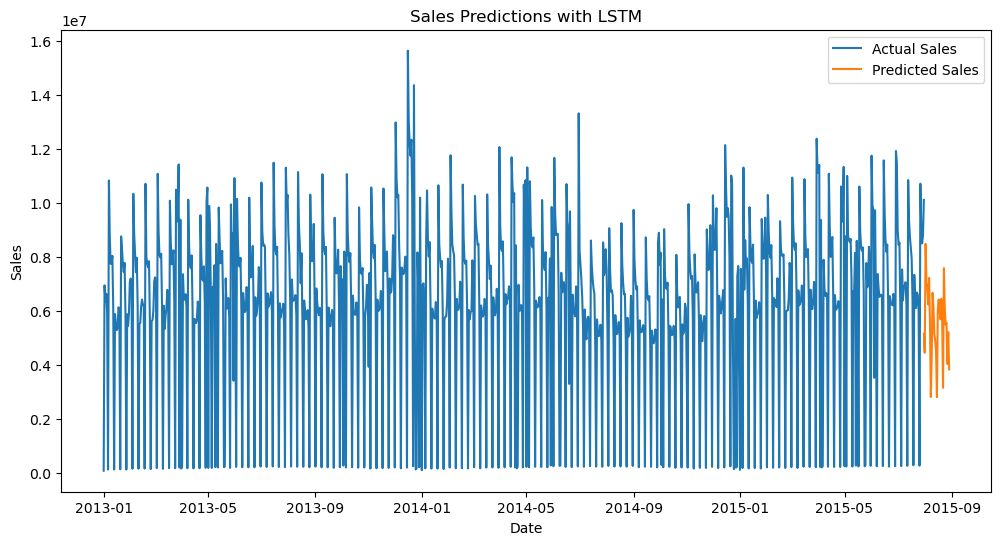

INFO:__main__:LSTM model saved to lstm_model_17-07-2024-19-15-42.h5


In [14]:
logger.info("Building LSTM model...")

# Isolate the Rossmann Store Sales dataset into time series data
daily_sales = train.groupby('Date')['Sales'].sum().reset_index()

# Check for stationarity using the Dickey-Fuller test
logger.info("Checking for stationarity...")
result = adfuller(daily_sales['Sales'])
logger.info('ADF Statistic: %f' % result[0])
logger.info('p-value: %f' % result[1])
for key, value in result[4].items():
    logger.info(f'Critical Values: {key}, {value}')

if result[1] > 0.05:
    logger.info("The series is non-stationary, applying differencing...")
    daily_sales['Sales_diff'] = daily_sales['Sales'].diff().dropna()
else:
    daily_sales['Sales_diff'] = daily_sales['Sales']

# Plot autocorrelation and partial autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(daily_sales['Sales_diff'].dropna(), ax=axes[0])
plot_pacf(daily_sales['Sales_diff'].dropna(), ax=axes[1])
plt.show()

# Transform the time series data into supervised learning data
window_size = 30
series = daily_sales['Sales_diff'].dropna().values
generator = TimeseriesGenerator(series, series, length=window_size, batch_size=1)

# Split the data into train and validation sets
train_size = int(len(generator) * 0.8)
train_generator = TimeseriesGenerator(series, series, length=window_size, batch_size=1, end_index=train_size)
val_generator = TimeseriesGenerator(series, series, length=window_size, batch_size=1, start_index=train_size)

# Build and train the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

logger.info("Training the LSTM model...")
model.fit(train_generator, epochs=20, validation_data=val_generator)

# Make predictions
pred_list = []
batch = series[-window_size:].reshape((1, window_size, 1))

for i in range(window_size):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[pred_list[-1]]], axis=1)

# Create a series for the predictions
pred_series = pd.Series(pred_list, index=pd.date_range(start=daily_sales['Date'].iloc[-1], periods=window_size, freq='D'))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], label='Actual Sales')
plt.plot(pred_series.index, pred_series, label='Predicted Sales')
plt.title('Sales Predictions with LSTM')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Serialize the LSTM model
timestamp = datetime.now().strftime('%d-%m-%Y-%H-%M-%S')
model_filename = f'lstm_model_{timestamp}.h5'
model.save(model_filename)
logger.info(f"LSTM model saved to {model_filename}")